In [1]:
import pyLIMA

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import csv
import cycler
from matplotlib.ticker import MaxNLocator
from bokeh.layouts import gridplot

from pyLIMA.fits import DE_fit
from pyLIMA.fits import TRF_fit
from pyLIMA.models import PSPL_model
from pyLIMA.models import FSPL_model
from pyLIMA.models import USBL_model, pyLIMA_fancy_parameters
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.toolbox import fake_telescopes, plots
from pyLIMA.parallax import parallax

from pyLIMA import event
from pyLIMA import telescopes


In [2]:
MARKER_SYMBOLS = np.array(
    [['o', '.', '*', 'v', '^', '<', '>', 's', 'p', 'd', 'x'] * 10])

thismodule = sys.modules[__name__]


thismodule.list_of_fake_telescopes = []
thismodule.saved_model = None

In [3]:
def plot_geometry(microlensing_model, model_parameters, bokeh_plot=None):
    """Plot the lensing geometry (i.e source trajectory) and the table of best
    parameters.
    :param object fit: a fit object. See the microlfits for more details.
    :param list best_parameters: a list containing the model you want to plot the
    trajectory
    """

    # Change matplotlib default colors
    n_telescopes = len(microlensing_model.event.telescopes)
    color = plt.cm.jet(
        np.linspace(0.01, 0.99, n_telescopes))  # This returns RGBA; convert:
    # hexcolor = map(lambda rgb: '#%02x%02x%02x' % (rgb[0] * 255, rgb[1] * 255,
    # rgb[2] * 255),
    #                tuple(color[:, 0:-1]))
    hexcolor = ['#' + format(int(i[0] * 255), 'x').zfill(2) + format(int(i[1] * 255),
                                                                     'x').zfill(2) +
                format(int(i[2] * 255), 'x').zfill(2) for i in color]

    matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler(color=hexcolor)

    pyLIMA_parameters = microlensing_model.compute_pyLIMA_parameters(model_parameters)

    faketelescopes = create_telescopes_to_plot_model(microlensing_model,
                                                     pyLIMA_parameters)

    fig_size = [10, 10]
    figure_trajectory = plt.figure(figsize=(fig_size[0], fig_size[1]), dpi=75)

    figure_axes = figure_trajectory.add_subplot(111, aspect=1)
    figure_axes.set_aspect('equal', adjustable='box')
    plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.9, wspace=0.1,
                        hspace=0.1)

    if bokeh_plot is not None:

        bokeh_geometry = figure(width=600, height=600, x_range=(-3, 3), y_range=(-3, 3),
                                x_axis_label=r'$$x [\theta_E]$$',
                                y_axis_label=r'$$y [\theta_E]$$')

    else:

        bokeh_geometry = None

    for telescope in faketelescopes:

        if telescope.lightcurve_flux is not None:

            platform = 'Earth'

            if telescope.location == 'Space':

                platform = telescope.name
                linestyle = '--'

            else:

                linestyle = '-'

            reference_telescope = telescope

            telescope_index = \
                [i for i in range(len(microlensing_model.event.telescopes)) if
                 microlensing_model.event.telescopes[i].name == telescope.name][0]

            trajectory_x, trajectory_y, dseparation, dalpha = \
                microlensing_model.source_trajectory(
                    telescope, pyLIMA_parameters,
                    data_type='photometry')

            color = plt.rcParams["axes.prop_cycle"].by_key()["color"][telescope_index]
            figure_axes.plot(trajectory_x, trajectory_y,
                             c=color,
                             label=platform, linestyle=linestyle)

            if bokeh_geometry is not None:
                bokeh_geometry.line(trajectory_x, trajectory_y,
                                    color=color,
                                    legend_label=platform)

            for ind in [-2, -1, 0, 1, 2]:

                try:

                    index = np.argmin(
                        np.abs(telescope.lightcurve_magnitude['time'].value -
                               (pyLIMA_parameters.t0 + ind * pyLIMA_parameters.tE)))
                    sign = np.sign(trajectory_x[index + 1] - trajectory_x[index])
                    derivative = (trajectory_y[index - 1] - trajectory_y[index + 1]) / (
                            trajectory_x[index - 1] - trajectory_x[index + 1])

                    figure_axes.annotate('',
                                         xy=(trajectory_x[index], trajectory_y[index]),
                                         xytext=(trajectory_x[index] - (
                                                 trajectory_x[index + 1] -
                                                 trajectory_x[index]) * 0.001,
                                                 trajectory_y[index] - (
                                                         trajectory_x[index + 1] -
                                                         trajectory_x[
                                                             index]) * 0.001 *
                                                 derivative),
                                         arrowprops=dict(arrowstyle="->",
                                                         mutation_scale=35,
                                                         color=color))

                    if bokeh_geometry is not None:
                        oh = OpenHead(line_color=color, line_width=1)

                        bokeh_geometry.add_layout(Arrow(end=oh,
                                                        x_start=trajectory_x[index],
                                                        y_start=trajectory_y[index],
                                                        x_end=trajectory_x[
                                                                  index] + sign * 0.001,
                                                        y_end=trajectory_y[
                                                                  index] + sign *
                                                              0.001 * derivative))

                except IndexError:

                    pass

            if microlensing_model.model_type == 'DSPL':

                _, _, trajectory_x, trajectory_y = \
                    microlensing_model.sources_trajectory(
                        reference_telescope,
                        pyLIMA_parameters)

                figure_axes.plot(trajectory_x, trajectory_y,
                                 c=color, alpha=0.5)

                if bokeh_geometry is not None:
                    bokeh_geometry.line(trajectory_x, trajectory_y,
                                        color=color, alpha=0.5)

    if 'BL' in microlensing_model.model_type():

        from pyLIMA.caustics import binary_caustics

        regime, caustics, cc = \
            binary_caustics.find_2_lenses_caustics_and_critical_curves(
                pyLIMA_parameters.separation,
                pyLIMA_parameters.mass_ratio,
                resolution=5000)

        center_of_mass = pyLIMA_parameters.separation * pyLIMA_parameters.mass_ratio / (
                1 + pyLIMA_parameters.mass_ratio)
        plt.scatter(-center_of_mass, 0, s=10, c='k')
        plt.scatter(-center_of_mass + pyLIMA_parameters.separation, 0, s=10, c='k')

        for count, caustic in enumerate(caustics):

            try:
                figure_axes.plot(caustic.real, caustic.imag, lw=3, c='r')
                figure_axes.plot(cc[count].real, cc[count].imag, '--k')

                if bokeh_geometry is not None:
                    bokeh_geometry.line(caustic.real, caustic.imag,
                                        color='red', line_width=3)
                    bokeh_geometry.line(cc[count].real, cc[count].imag,
                                        line_dash='dashed',
                                        color='black')

            except AttributeError:

                pass

    else:

        figure_axes.scatter(0, 0, s=10, c='r')

        einstein_ring = plt.Circle((0, 0), 1, fill=False, color='k', linestyle='--')
        figure_axes.add_artist(einstein_ring)

        if bokeh_geometry is not None:
            bokeh_geometry.scatter(0, 0, color='red')
            bokeh_geometry.circle(0, 0, radius=1, line_dash='dashed',
                                  line_color='black', fill_color=None)

    for telescope_index, telescope in enumerate(microlensing_model.event.telescopes):

        if telescope.lightcurve_flux is not None:

            trajectory_x, trajectory_y, dseparation, dalpha = \
                microlensing_model.source_trajectory(
                    telescope,
                    pyLIMA_parameters,
                    data_type='photometry')

            if 'rho' in microlensing_model.pyLIMA_standards_dictionnary.keys():

                rho = pyLIMA_parameters.rho

            else:

                rho = 10 ** -5

            color = plt.rcParams["axes.prop_cycle"].by_key()["color"][telescope_index]

            patches = [plt.Circle((x, y), rho, color=color,
                                  alpha=0.2) for x, y in
                       zip(trajectory_x, trajectory_y)]
            coll = matplotlib.collections.PatchCollection(patches, match_original=True)

            figure_axes.scatter(trajectory_x, trajectory_y,
                                c=color,
                                alpha=0.5, label=telescope.name, s=0.1)

            figure_axes.add_collection(coll)

            if bokeh_geometry is not None:
                bokeh_geometry.circle(trajectory_x, trajectory_y, radius=rho,
                                      color=color,
                                      radius_dimension='max', fill_alpha=0.5)

    if microlensing_model.parallax_model[0] != 'None':

        origin_t0par_index = np.argmin(
            np.abs(telescope.lightcurve_magnitude['time'].value -
                   microlensing_model.parallax_model[1]))

        origin_t0par = np.array(
            (trajectory_x[origin_t0par_index], trajectory_y[origin_t0par_index]))
        # origin_t0par += 0.1

        piEN = pyLIMA_parameters.piEN
        piEE = pyLIMA_parameters.piEE

        EN_trajectory_angle = parallax.EN_trajectory_angle(piEN, piEE)

        plot_angle = -EN_trajectory_angle

        try:

            plot_angle += pyLIMA_parameters.alpha

        except AttributeError:

            pass

        north = [0.1, 0]
        east = [0, 0.1]

        North = [0.105, 0]
        East = [0, 0.105]

        rota_mat = np.array([[np.cos(plot_angle), -np.sin(plot_angle)],
                             [np.sin(plot_angle), np.cos(plot_angle)]])

        east = np.dot(rota_mat, east)
        north = np.dot(rota_mat, north)
        East = np.dot(rota_mat, East)
        North = np.dot(rota_mat, North)

        plt.annotate('',
                     xy=(origin_t0par[0] + east[0], origin_t0par[1] + east[1]),
                     xytext=(origin_t0par[0], origin_t0par[1]),
                     arrowprops=dict(arrowstyle="->", lw=3, alpha=0.5))
        plt.annotate('E', xy=(origin_t0par[0] + East[0], origin_t0par[1] + East[1]),
                     xytext=(origin_t0par[0] + East[0], origin_t0par[1] + East[1]),
                     weight='bold', alpha=0.5, ha='center', va='center',
                     rotation=np.rad2deg(plot_angle))

        plt.annotate('', xy=(
            origin_t0par[0] + north[0], origin_t0par[1] + north[1]),
                     xytext=(origin_t0par[0], origin_t0par[1]),
                     arrowprops=dict(arrowstyle="->", lw=3, alpha=0.5))
        plt.annotate('N',
                     xy=(origin_t0par[0] + North[0], origin_t0par[1] + North[1]),
                     xytext=(
                         origin_t0par[0] + North[0], origin_t0par[1] + North[1]),
                     weight='bold', alpha=0.5, ha='center', va='center',
                     rotation=np.rad2deg(plot_angle))

        if bokeh_geometry is not None:
            bokeh_geometry.add_layout(
                Arrow(end=OpenHead(line_color="grey", line_width=1),
                      x_start=origin_t0par[0], y_start=origin_t0par[1],
                      x_end=origin_t0par[0] + North[0],
                      y_end=origin_t0par[1] + North[1]))
            bokeh_geometry.add_layout(
                Arrow(end=OpenHead(line_color="grey", line_width=1),
                      x_start=origin_t0par[0], y_start=origin_t0par[1],
                      x_end=origin_t0par[0] + East[0],
                      y_end=origin_t0par[1] + East[1]))
    # legend = figure_axes.legend(numpoints=1, loc='best', fancybox=True,
    # framealpha=0.5)
    legend = figure_axes.legend(shadow=True, fontsize='large',
                                bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                                mode="expand", borderaxespad=0, ncol=3, numpoints=1)

    for handle in legend.legendHandles:

        try:

            handle.set_sizes([100])

        except AttributeError:

            pass

    figure_axes.xaxis.set_major_locator(MaxNLocator(5))
    figure_axes.yaxis.set_major_locator(MaxNLocator(5))
    figure_axes.xaxis.get_major_ticks()[0].draw = lambda *args: None
    figure_axes.yaxis.get_major_ticks()[0].draw = lambda *args: None
    figure_axes.xaxis.get_major_ticks()[-1].draw = lambda *args: None
    figure_axes.yaxis.get_major_ticks()[-1].draw = lambda *args: None

    figure_axes.set_xlabel(r'$x(\theta_E)$', fontsize=25)
    figure_axes.set_ylabel(r'$y(\theta_E)$', fontsize=25)
    figure_axes.tick_params(axis='x', labelsize=15)
    figure_axes.tick_params(axis='y', labelsize=15)

    figure_axes.axis([-2, 2, -2, 2])
    # figure_axes.axis('scaled')
    # title = microlensing_model.event.name + ' : ' + microlensing_model.model_type
    # figure_trajectory.suptitle(title, fontsize=30 * fig_size[0] / len(title))

    return figure_trajectory, bokeh_geometry

########################################################################################
########################################################################################

def plot_residuals(figure_axe, microlensing_model, model_parameters, bokeh_plot=None,
                   plot_unit='Mag'):
    pyLIMA_parameters = microlensing_model.compute_pyLIMA_parameters(model_parameters)

    # plot residuals

    for ind, tel in enumerate(microlensing_model.event.telescopes):

        if tel.lightcurve_flux is not None:
            residus_in_mag = \
                pyLIMA.fits.objective_functions.photometric_residuals_in_magnitude(
                    tel, microlensing_model, pyLIMA_parameters)

            color = plt.rcParams["axes.prop_cycle"].by_key()["color"][ind]
            marker = str(MARKER_SYMBOLS[0][ind])

            plots.plot_light_curve_magnitude(tel.lightcurve_magnitude['time'].value,
                                             residus_in_mag,
                                             tel.lightcurve_magnitude['err_mag'].value,
                                             figure_axe=figure_axe, color=color,
                                             marker=marker, name=tel.name)

        if bokeh_plot is not None:

            bokeh_plot.scatter(tel.lightcurve_magnitude['time'].value,
                               residus_in_mag,
                               color=color,
                               size=5,
                               muted_color=color,
                               muted_alpha=0.2)

            err_xs = []
            err_ys = []

            for x, y, yerr in zip(tel.lightcurve_magnitude['time'].value,
                                  residus_in_mag,
                                  tel.lightcurve_magnitude['err_mag'].value):
                err_xs.append((x, x))
                err_ys.append((y - yerr, y + yerr))

            bokeh_plot.multi_line(err_xs, err_ys, color=color,
                                  muted_color=color,
                                  muted_alpha=0.2)

    figure_axe.set_ylim([-0.1, 0.1])

#######################################################################################
########################################################################################

def plot_aligned_data(figure_axe, microlensing_model, model_parameters, bokeh_plot=None,
                      plot_unit='Mag'):
    pyLIMA_parameters = microlensing_model.compute_pyLIMA_parameters(model_parameters)

    # plot aligned data
    index = 0

    list_of_telescopes = create_telescopes_to_plot_model(microlensing_model,
                                                         pyLIMA_parameters)

    ref_names = []
    ref_locations = []
    ref_magnification = []
    ref_fluxes = []

    for ref_tel in list_of_telescopes:
        model_magnification = microlensing_model.model_magnification(ref_tel,
                                                                     pyLIMA_parameters)

        microlensing_model.derive_telescope_flux(ref_tel, pyLIMA_parameters,
                                                 model_magnification)

        f_source = getattr(pyLIMA_parameters, 'fsource_' + ref_tel.name)
        f_blend = getattr(pyLIMA_parameters, 'fblend_' + ref_tel.name)

        # model_magnification = (model['photometry']-f_blend)/f_source

        ref_names.append(ref_tel.name)
        ref_locations.append(ref_tel.location)
        ref_magnification.append(model_magnification)
        ref_fluxes.append([f_source, f_blend])

    for ind, tel in enumerate(microlensing_model.event.telescopes):

        if tel.lightcurve_flux is not None:

            if tel.location == 'Earth':

                ref_index = np.where(np.array(ref_locations) == 'Earth')[0][0]

            else:

                ref_index = np.where(np.array(ref_names) == tel.name)[0][0]

            residus_in_mag = \
                pyLIMA.fits.objective_functions.photometric_residuals_in_magnitude(
                    tel, microlensing_model,
                    pyLIMA_parameters)
            if ind == 0:
                reference_source = ref_fluxes[ind][0]
                reference_blend = ref_fluxes[ind][1]
                index += 1

            # time_mask = [False for i in range(len(ref_magnification[ref_index]))]
            time_mask = []
            for time in tel.lightcurve_flux['time'].value:
                time_index = np.where(list_of_telescopes[ref_index].lightcurve_flux[
                                          'time'].value == time)[0][0]
                time_mask.append(time_index)

            # model_flux = ref_fluxes[ref_index][0] * ref_magnification[ref_index][
            #    time_mask] + ref_fluxes[ref_index][1]
            model_flux = reference_source * ref_magnification[ref_index][
                time_mask] + reference_blend
            magnitude = pyLIMA.toolbox.brightness_transformation.ZERO_POINT - 2.5 * \
                        np.log10(model_flux)

            color = plt.rcParams["axes.prop_cycle"].by_key()["color"][ind]
            marker = str(MARKER_SYMBOLS[0][ind])

            plots.plot_light_curve_magnitude(tel.lightcurve_magnitude['time'].value,
                                             magnitude + residus_in_mag,
                                             tel.lightcurve_magnitude['err_mag'].value,
                                             figure_axe=figure_axe, color=color,
                                             marker=marker, name=tel.name)

            if bokeh_plot is not None:

                bokeh_plot.scatter(tel.lightcurve_magnitude['time'].value,
                                   magnitude + residus_in_mag,
                                   color=color,
                                   size=5, legend_label=tel.name,
                                   muted_color=color,
                                   muted_alpha=0.2)

                err_xs = []
                err_ys = []

                for x, y, yerr in zip(tel.lightcurve_magnitude['time'].value,
                                      magnitude + residus_in_mag,
                                      tel.lightcurve_magnitude['err_mag'].value):
                    err_xs.append((x, x))
                    err_ys.append((y - yerr, y + yerr))

                bokeh_plot.multi_line(err_xs, err_ys, color=color,
                                      legend_label=tel.name,
                                      muted_color=color,
                                      muted_alpha=0.2)

#####################################################################################
#####################################################################################

def create_telescopes_to_plot_model(microlensing_model, pyLIMA_parameters):
    if microlensing_model == thismodule.saved_model:

        list_of_fake_telescopes = thismodule.list_of_fake_telescopes

    else:

        list_of_fake_telescopes = []

    if len(list_of_fake_telescopes) == 0:

        # Photometry first
        Earth = True

        for tel in microlensing_model.event.telescopes:

            if tel.lightcurve_flux is not None:

                if tel.location == 'Space':
                    model_time = np.arange(
                        np.min(tel.lightcurve_magnitude['time'].value),
                        np.max(tel.lightcurve_magnitude['time'].value),
                        0.1).round(2)

                    model_time = np.r_[
                        model_time, tel.lightcurve_magnitude['time'].value]

                    model_time.sort()

                if Earth and tel.location == 'Earth':

                    model_time1 = np.arange(np.min((np.min(
                        tel.lightcurve_magnitude['time'].value),
                                                    pyLIMA_parameters.t0 - 5 *
                                                    pyLIMA_parameters.tE)),
                        np.max((np.max(
                            tel.lightcurve_magnitude['time'].value),
                                pyLIMA_parameters.t0 + 5 *
                                pyLIMA_parameters.tE)),
                        1).round(2)

                    model_time2 = np.arange(
                        pyLIMA_parameters.t0 - 1 * pyLIMA_parameters.tE,
                        pyLIMA_parameters.t0 + 1 * pyLIMA_parameters.tE,
                        1).round(2)

                    model_time = np.r_[model_time1, model_time2]

                    for telescope in microlensing_model.event.telescopes:

                        if telescope.location == 'Earth':
                            model_time = np.r_[
                                model_time, telescope.lightcurve_magnitude[
                                    'time'].value]

                            symmetric = 2 * pyLIMA_parameters.t0 - \
                                        telescope.lightcurve_magnitude['time'].value
                            model_time = np.r_[model_time, symmetric]

                    model_time.sort()

                if (tel.location == 'Space') | (Earth and tel.location == 'Earth'):

                    model_time = np.unique(model_time)

                    model_lightcurve = np.c_[
                        model_time, [0] * len(model_time), [0.1] * len(model_time)]
                    model_telescope = fake_telescopes.create_a_fake_telescope(
                        light_curve=model_lightcurve)

                    model_telescope.name = tel.name
                    model_telescope.filter = tel.filter
                    model_telescope.location = tel.location
                    model_telescope.ld_gamma = tel.ld_gamma
                    model_telescope.ld_sigma = tel.ld_sigma
                    model_telescope.ld_a1 = tel.ld_a1
                    model_telescope.ld_a2 = tel.ld_a2
                    model_telescope.location = tel.location

                    if tel.location == 'Space':
                        model_telescope.spacecraft_name = tel.spacecraft_name
                        model_telescope.spacecraft_positions = tel.spacecraft_positions

                    if microlensing_model.parallax_model[0] != 'None':
                        model_telescope.initialize_positions()

                        model_telescope.compute_parallax(
                            microlensing_model.parallax_model,
                            microlensing_model.event.North
                            ,
                            microlensing_model.event.East)  # ,
                        # microlensing_model.event.ra/180*np.pi)

                    list_of_fake_telescopes.append(model_telescope)

                    if tel.location == 'Earth' and Earth:
                        Earth = False

        # Astrometry

        for tel in microlensing_model.event.telescopes:

            if tel.astrometry is not None:

                if tel.location == 'Space':

                    model_time = np.arange(np.min(tel.astrometry['time'].value),
                                           np.max(tel.astrometry['time'].value),
                                           0.1).round(2)
                else:

                    model_time1 = np.arange(
                        np.min((np.min(tel.lightcurve_magnitude['time'].value),
                                pyLIMA_parameters.t0 - 5 * pyLIMA_parameters.tE)),
                        np.max((np.max(tel.lightcurve_magnitude['time'].value),
                                pyLIMA_parameters.t0 + 5 * pyLIMA_parameters.tE)),
                        1).round(2)

                    model_time2 = np.arange(
                        pyLIMA_parameters.t0 - 1 * pyLIMA_parameters.tE,
                        pyLIMA_parameters.t0 + 1 * pyLIMA_parameters.tE,
                        0.1).round(2)

                    model_time = np.r_[model_time1, model_time2]

                    model_time = np.r_[model_time, telescope.astrometry['time'].value]

                    symmetric = 2 * pyLIMA_parameters.t0 - telescope.astrometry[
                        'time'].value
                    model_time = np.r_[model_time, symmetric]
                    model_time.sort()

                model_time = np.unique(model_time)
                model_astrometry = np.c_[
                    model_time, [0] * len(model_time), [0.1] * len(model_time), [
                        0] * len(model_time), [0.1] * len(model_time)]
                model_telescope = fake_telescopes.create_a_fake_telescope(
                    astrometry_curve=model_astrometry,
                    astrometry_unit=tel.astrometry['ra'].unit)

                model_telescope.name = tel.name
                model_telescope.filter = tel.filter
                model_telescope.location = tel.location
                model_telescope.ld_gamma = tel.ld_gamma
                model_telescope.ld_sigma = tel.ld_sigma
                model_telescope.ld_a1 = tel.ld_a1
                model_telescope.ld_a2 = tel.ld_a2
                model_telescope.pixel_scale = tel.pixel_scale

                if tel.location == 'Space':
                    model_telescope.spacecraft_name = tel.spacecraft_name
                    model_telescope.spacecraft_positions = tel.spacecraft_positions

                if microlensing_model.parallax_model[0] != 'None':
                    model_telescope.initialize_positions()

                    model_telescope.compute_parallax(microlensing_model.parallax_model,
                                                     microlensing_model.event.North
                                                     ,
                                                     microlensing_model.event.East)  # ,
                    # microlensing_model.event.ra / 180)# * np.pi)

                list_of_fake_telescopes.append(model_telescope)

        thismodule.saved_model = microlensing_model
        thismodule.list_of_fake_telescopes = list_of_fake_telescopes

    return list_of_fake_telescopes

###################################################################
###################################################################

def plot_photometric_models(figure_axe, microlensing_model, model_parameters,
                            bokeh_plot=None, plot_unit='Mag'):
    pyLIMA_parameters = microlensing_model.compute_pyLIMA_parameters(model_parameters)

    list_of_telescopes = create_telescopes_to_plot_model(microlensing_model,
                                                         pyLIMA_parameters)
    telescopes_names = np.array([i.name for i in microlensing_model.event.telescopes])

    # plot models
    index = 0

    for tel in list_of_telescopes:

        if tel.lightcurve_flux is not None:

            magni = microlensing_model.model_magnification(tel, pyLIMA_parameters)
            microlensing_model.derive_telescope_flux(tel, pyLIMA_parameters, magni)

            f_source = getattr(pyLIMA_parameters, 'fsource_' + tel.name)
            f_blend = getattr(pyLIMA_parameters, 'fblend_' + tel.name)

            if index == 0:
                ref_source = f_source
                ref_blend = f_blend
                index += 1

            magnitude = pyLIMA.toolbox.brightness_transformation.ZERO_POINT - 2.5 * \
                        np.log10(ref_source * magni + ref_blend)

            # delta_mag = -2.5 * np.log10(f_source + f_blend) + 2.5 * np.log10(
            ##     ref_source + ref_blend)
            # magnitude -= delta_mag

            name = tel.name

            index_color = np.where(name == telescopes_names)[0][0]
            color = plt.rcParams["axes.prop_cycle"].by_key()["color"][index_color]

            if tel.location == 'Earth':

                name = tel.location
                linestyle = '-'

            else:

                linestyle = '--'

            plots.plot_light_curve_magnitude(tel.lightcurve_magnitude['time'].value,
                                             magnitude, figure_axe=figure_axe,
                                             name=name, color=color,
                                             linestyle=linestyle)

            if bokeh_plot is not None:
                bokeh_plot.line(tel.lightcurve_magnitude['time'].value, magnitude,
                                legend_label=name, color=color)

###############################################################################
###############################################################################

# Main func that controls the displayed plots

def initialize_light_curves_plot(plot_unit='Mag', event_name='A microlensing event'):
    fig_size = [10, 10]
    mat_figure, mat_figure_axes = plt.subplots(2, 1, sharex=True,
                                               gridspec_kw={'height_ratios': [3, 1]},
                                               figsize=(fig_size[0], fig_size[1]),
                                               dpi=75)
    plt.subplots_adjust(top=0.8, bottom=0.15, left=0.2, right=0.9, wspace=0.1,
                        hspace=0.1)
    mat_figure_axes[0].grid()
    mat_figure_axes[1].grid()
    # mat_figure.suptitle(event_name, fontsize=30 * fig_size[0] / len(event_name))

    mat_figure_axes[0].set_ylabel('Mag',
                                  fontsize=5 * fig_size[1] * 3 / 4.0)
    mat_figure_axes[0].yaxis.set_major_locator(MaxNLocator(4))
    mat_figure_axes[0].tick_params(axis='y', labelsize=10)

    mat_figure_axes[0].text(0.01, 0.96, 'provided by pyLIMA', style='italic',
                            fontsize=10,
                            transform=mat_figure_axes[0].transAxes)

    mat_figure_axes[1].set_xlabel('JD', fontsize=5 * fig_size[0] * 3 / 4.0)
    mat_figure_axes[1].xaxis.set_major_locator(MaxNLocator(3))
    mat_figure_axes[1].yaxis.set_major_locator(MaxNLocator(4, min_n_ticks=3))

    mat_figure_axes[1].ticklabel_format(useOffset=False, style='plain')
    mat_figure_axes[1].set_ylabel('$\Delta M$', fontsize=5 * fig_size[1] * 2 / 4.0)
    mat_figure_axes[1].tick_params(axis='x', labelsize=10)
    mat_figure_axes[1].tick_params(axis='y', labelsize=10)

    return mat_figure, mat_figure_axes

#######################################################################
########################################################################

def plot_lightcurves(microlensing_model, model_parameters, bokeh_plot=None):
    # Change matplotlib default colors
    n_telescopes = len(microlensing_model.event.telescopes)
    color = plt.cm.jet(
        np.linspace(0.01, 0.99, n_telescopes))  # This returns RGBA; convert:
    # hexcolor = map(lambda rgb: '#%02x%02x%02x' % (rgb[0] * 255, rgb[1] * 255,
    # rgb[2] * 255),
    #                tuple(color[:, 0:-1]))
    hexcolor = ['#' + format(int(i[0] * 255), 'x').zfill(2) + format(int(i[1] * 255),
                                                                     'x').zfill(2) +
                format(int(i[2] * 255), 'x').zfill(2) for i in color]

    matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler(color=hexcolor)

    mat_figure, mat_figure_axes = initialize_light_curves_plot(
        event_name=microlensing_model.event.name)

    if bokeh_plot is not None:

        bokeh_lightcurves = figure(figsize=(800,600), toolbar_location=None,
                                   y_axis_label='Mag')
        bokeh_residuals = figure(figsize=(800,600),
                                 x_range=bokeh_lightcurves.x_range,
                                 y_range=(0.18, -0.18), toolbar_location=None,
                                 x_axis_label='JD', y_axis_label='Delta_M')

        bokeh_lightcurves.xaxis.minor_tick_line_color = None
        bokeh_lightcurves.xaxis.major_tick_line_color = None
        bokeh_lightcurves.xaxis.major_label_text_font_size = '0pt'
        bokeh_lightcurves.y_range.flipped = True
        bokeh_lightcurves.xaxis.formatter = BasicTickFormatter(use_scientific=False)

        bokeh_residuals.xaxis.formatter = BasicTickFormatter(use_scientific=False)
        bokeh_residuals.xaxis.major_label_orientation = np.pi / 4
        bokeh_residuals.xaxis.minor_tick_line_color = None

    else:

        bokeh_lightcurves = None
        bokeh_residuals = None

    if len(model_parameters) != len(microlensing_model.model_dictionnary):
        telescopes_fluxes = microlensing_model.find_telescopes_fluxes(model_parameters)
        telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
                             telescopes_fluxes._fields]

        model_parameters = np.r_[model_parameters, telescopes_fluxes]

    plot_photometric_models(mat_figure_axes[0], microlensing_model, model_parameters,
                            plot_unit='Mag',
                            bokeh_plot=bokeh_lightcurves)

    plot_aligned_data(mat_figure_axes[0], microlensing_model, model_parameters,
                      plot_unit='Mag',
                      bokeh_plot=bokeh_lightcurves)

    plot_residuals(mat_figure_axes[1], microlensing_model, model_parameters,
                   plot_unit='Mag',
                   bokeh_plot=bokeh_residuals)

    mat_figure_axes[0].invert_yaxis()
    mat_figure_axes[1].invert_yaxis()
    mat_figure_axes[0].legend(shadow=True, fontsize='large',
                              bbox_to_anchor=(0, 1.02, 1, 0.2),
                              loc="lower left",
                              mode="expand", borderaxespad=0, ncol=3)

    try:
        bokeh_lightcurves.legend.click_policy = "mute"
        # legend = bokeh_lightcurves.legend[0]

    except AttributeError:

        pass

    #figure_bokeh = gridplot([[bokeh_lightcurves], [bokeh_residuals]], toolbar_location=None, width=1200, height=1000)

    return mat_figure, bokeh_lightcurves, bokeh_residuals


In [4]:
your_event = event.Event(ra=262.75616,dec=-21.40123)   # setting no parallax for starters
your_event.name = 'Gaia21bsg_binary'

data_1 = np.loadtxt('data/star_20957_Gaia21bsg_fs01_ip_reduced.dat')
telescope_1 = telescopes.Telescope(name='Gaia_20957_i',
                                  camera_filter = 'I',
                                  light_curve = data_1.astype(float),
                                  light_curve_names = ['time','mag','err_mag'],
                                  light_curve_units = ['JD','mag','mag'])

data_2 = np.loadtxt('data/star_50085_Gaia21bsg_gp_reduced.dat')
telescope_2 = telescopes.Telescope(name='Gaia__50085_g',
                                  camera_filter = 'G',
                                  light_curve = data_2.astype(float),
                                  light_curve_names = ['time','mag','err_mag'],
                                  light_curve_units = ['JD','mag','mag'])

data_3 = np.loadtxt('data/star_79874_Gaia21bsg_ip_reduced.dat')
telescope_3 = telescopes.Telescope(name='Gaia_79874_i',
                                  camera_filter = 'I',
                                  light_curve = data_3.astype(float),
                                  light_curve_names = ['time','mag','err_mag'],
                                  light_curve_units = ['JD','mag','mag'])

#data_4 = np.loadtxt('data/reduced_ztf.dat',delimiter=' ')   # Removing ZTF data for normalization issues
#telescope_4 = telescopes.Telescope(name='ZTF_r',
#                                  camera_filter = 'R',
#                                  light_curve = data_4.astype(float),
#                                  light_curve_names = ['time','mag','err_mag'],
#                                  light_curve_units = ['JD','mag','mag'])

data_5 = np.loadtxt('data/reduced_gaia.dat',delimiter=' ')
telescope_5 = telescopes.Telescope(name='Gaia_g',
                                  camera_filter = 'G',
                                  light_curve = data_5.astype(float),
                                  light_curve_names = ['time','mag','err_mag'],
                                  light_curve_units = ['JD', 'mag','mag'])

your_event.telescopes.append(telescope_1)
your_event.telescopes.append(telescope_2)
your_event.telescopes.append(telescope_3)
#your_event.telescopes.append(telescope_4)   # remove this as well
your_event.telescopes.append(telescope_5)

your_event.find_survey('Gaia')
your_event.check_event()


check_event  : Everything looks fine...


In [5]:
from pyLIMA.fits import MCMC_fit
import multiprocessing as mul
from pyLIMA.fits import stats

pool = mul.Pool(processes=2)

fancy = pyLIMA_fancy_parameters.standard_fancy_parameters
usbl = USBL_model.USBLmodel(your_event,fancy_parameters=fancy,parallax=['None',2.45935341e+06])   # defining usbl model

# Now using MCMC fit instead of DE fit
fit_2 = MCMC_fit.MCMCfit(usbl)   # wrapping mcmc fit algorithm around usbl model

# print(fit_2.fit_parameters.keys())

# keys = [t0, u0, log_tE, log_rho, log_separation, log_mass_ratio, alpha]

# prev noZTF best model fit results
# setting initial parameter guess and parameter constraints
fit_2.model_parameters_guess = [2.45935341e+06, 1.48791735e-01, 2.65444058e+00, -2.62081329e+00, -1.63126084e-01, -8.10868845e-02, -3.30072563e-01]

fit_2.fit_parameters['t0'][1] = [2459282.00, 2459413.00] # t0 limits, changed
fit_2.fit_parameters['u0'][1] = [-0.5, 0.5] # u0 limits, computed and changed
fit_2.fit_parameters['log_tE'][1] = [0.0,3.0] # logtE limits in days, changed from log(20) - log(150)

fit_2.fit_parameters['log_rho'][1] = [-6.042577190325831, -1]
fit_2.fit_parameters['log_separation'][1] = [-1.0,1.0] # log_s limits,
fit_2.fit_parameters['log_mass_ratio'][1] = [-5, 8.15962396e-03] # log_q limits,
fit_2.fit_parameters['alpha'][1] = [-3.14, 3.14] # alpha limits (in radians)

In [6]:
fit_2.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459353.41, 0.148791735, 2.65444058, -2.62081329, -0.163126084, -0.0810868845, 3.087375724275921]


100%|███████████████████████████████████████| 5000/5000 [45:19<00:00,  1.84it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best_model: [ 2.45935349e+06  1.79693074e-01  2.69896975e+00 -2.64684691e+00
 -2.09462359e-01 -6.46225999e-02  3.08180901e+00 -2.55605734e+03
  1.82768296e+04  6.92464400e+00  2.19968967e+02  3.73153361e+01
  1.00987787e+03  7.09892525e+02  5.30450946e+02] ln(likelihood) -46407.03675603119


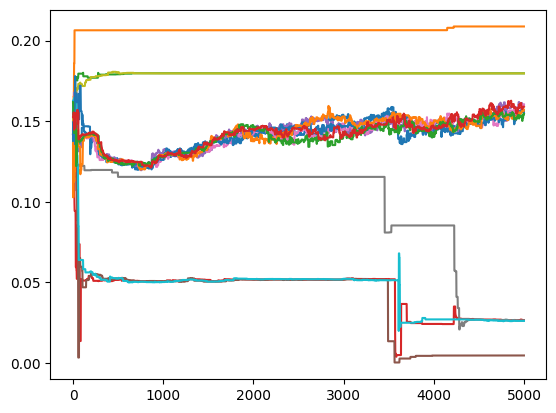

In [7]:
plt.close('all')
plt.plot(fit_2.fit_results['MCMC_chains'][:,:,1])   # u0
plt.show()

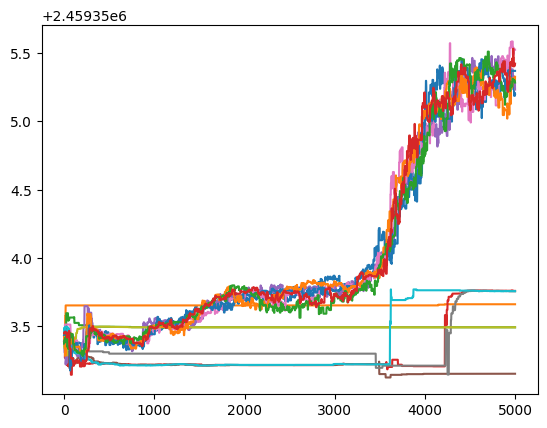

In [8]:
plt.close('all')
plt.plot(fit_2.fit_results['MCMC_chains'][:,:,0])   # t0
plt.show()

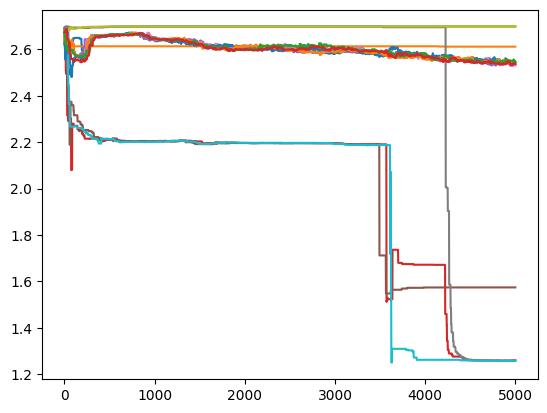

In [9]:
plt.close('all')
plt.plot(fit_2.fit_results['MCMC_chains'][:,:,2])   # log_tE
plt.show()

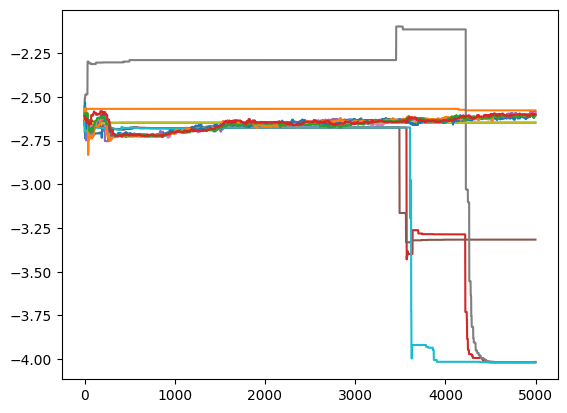

In [10]:
plt.close('all')
plt.plot(fit_2.fit_results['MCMC_chains'][:,:,3])   # log_rho
plt.show()

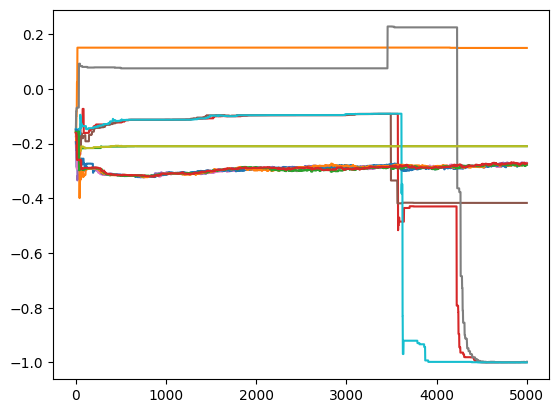

In [11]:
plt.close('all')
plt.plot(fit_2.fit_results['MCMC_chains'][:,:,4])   # log_sep
plt.show()

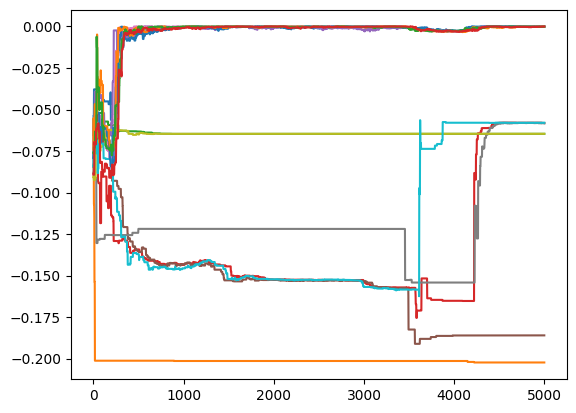

In [12]:
plt.close('all')
plt.plot(fit_2.fit_results['MCMC_chains'][:,:,5])   # log_mass_ratio
plt.show()

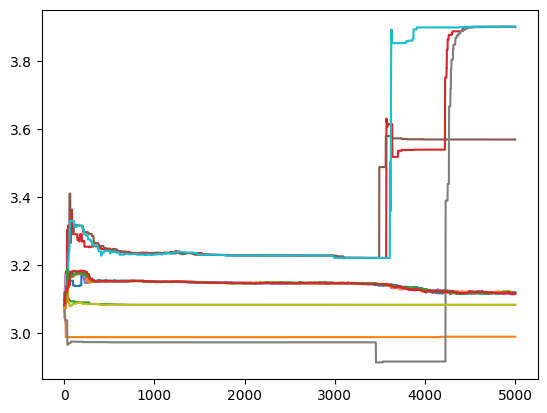

In [13]:
plt.close('all')
plt.plot(fit_2.fit_results['MCMC_chains'][:,:,6])   # alpha
plt.show()

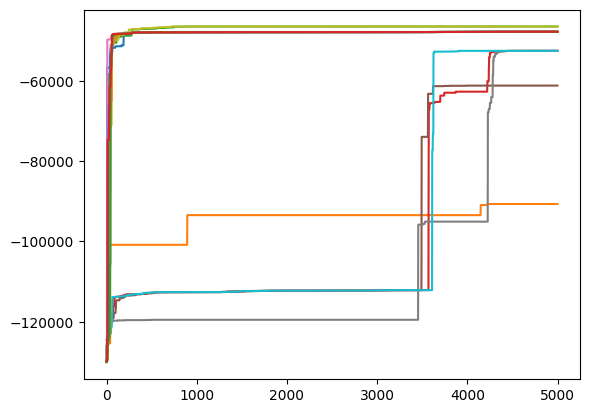

In [14]:
plt.close('all')
plt.plot(fit_2.fit_results['MCMC_chains'][:,:,7])   # likelihood
plt.show()

In [16]:
MCMC_results = fit_2.fit_results['MCMC_chains']
print ('Parameters', ' Model','   Fit','     Errors')
print ('-----------------------------------')
print ('t_0:', '        2.45935341e+06 ',str(np.median(MCMC_results[1000:,:,0]))[:7],'',str(np.std(MCMC_results[1000:,:,0]))[:7])
print ('u_0:', '        1.48791735e-01 ',str(np.median(MCMC_results[1000:,:,1]))[:7],'',str(np.std(MCMC_results[1000:,:,1]))[:7])
print ('log_tE:', '        2.65444058e+00 ',str(np.median(MCMC_results[1000:,:,2]))[:7],'',str(np.std(MCMC_results[1000:,:,2]))[:7])
print ('log_rho:', '        -2.62081329e+00 ',str(np.median(MCMC_results[1000:,:,3]))[:7],'',str(np.std(MCMC_results[1000:,:,3]))[:7])
print ('log_separation:', '        -1.63126084e-01 ',str(np.median(MCMC_results[1000:,:,4]))[:7],'',str(np.std(MCMC_results[1000:,:,4]))[:7])
print ('log_mass_ratio:', '        -8.10868845e-02 ',str(np.median(MCMC_results[1000:,:,5]))[:7],'',str(np.std(MCMC_results[1000:,:,5]))[:7])
print ('alpha:', '        -3.30072563e-01 ',str(np.median(MCMC_results[1000:,:,6]))[:7],'',str(np.std(MCMC_results[1000:,:,6]))[:7])

Parameters  Model    Fit      Errors
-----------------------------------
t_0:         2.45935341e+06  2459353  0.62461
u_0:         1.48791735e-01  0.14464  0.05381
log_tE:         2.65444058e+00  2.59820  0.36492
log_rho:         -2.62081329e+00  -2.6468  0.34193
log_separation:         -1.63126084e-01  -0.2812  0.22879
log_mass_ratio:         -8.10868845e-02  -0.0299  0.07210
alpha:         -3.30072563e-01  3.14469  0.19955


In [17]:
from matplotlib.pyplot import hist2d
from matplotlib.colors import LogNorm

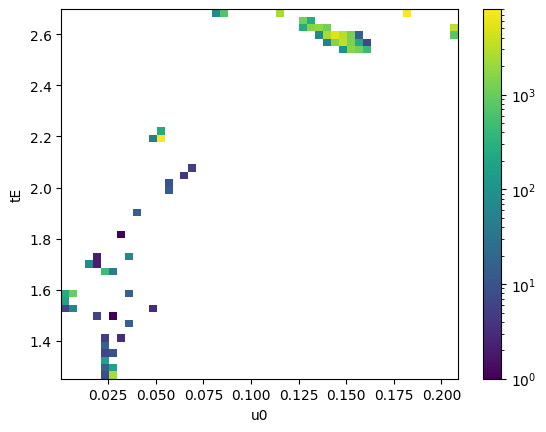

In [18]:
plt.close('all')
plt.hist2d(MCMC_results[1000:,:,1].ravel(),MCMC_results[1000:,:,2].ravel(), norm=LogNorm(), bins=50)
plt.xlabel('u0')
plt.ylabel('tE')
plt.colorbar()
plt.show()

In [19]:
samples_without_ln_like = fit_2.fit_results["MCMC_chains"][:,:,:5]

In [20]:
print(fit_2.fit_results['MCMC_chains'])
print(fit_2.fit_results['MCMC_chains'].shape)

[[[ 2.45935340e+06  1.42131039e-01  2.67670421e+00 ... -6.52864884e-02
    3.10021091e+00 -1.27092464e+05]
  [ 2.45935343e+06  1.50011362e-01  2.67503177e+00 ... -8.44971583e-02
    3.07906380e+00 -1.29923497e+05]
  [ 2.45935341e+06  1.56289949e-01  2.68323598e+00 ... -7.31567277e-02
    3.09601052e+00 -1.30026951e+05]
  ...
  [ 2.45935342e+06  1.36537519e-01  2.64886293e+00 ... -7.41348681e-02
    3.08733569e+00 -1.29713115e+05]
  [ 2.45935337e+06  1.61902231e-01  2.67197699e+00 ... -7.57792226e-02
    3.07985284e+00 -1.29985494e+05]
  [ 2.45935345e+06  1.52538231e-01  2.67493856e+00 ... -8.91330266e-02
    3.08281751e+00 -1.29833561e+05]]

 [[ 2.45935338e+06  1.34226549e-01  2.69662343e+00 ... -5.37492668e-02
    3.10523264e+00 -1.25806085e+05]
  [ 2.45935343e+06  1.50011362e-01  2.67503177e+00 ... -8.44971583e-02
    3.07906380e+00 -1.29923497e+05]
  [ 2.45935341e+06  1.56289949e-01  2.68323598e+00 ... -7.31567277e-02
    3.09601052e+00 -1.30026951e+05]
  ...
  [ 2.45935341e+06  1.2

In [21]:
np.shape(fit_2.fit_results["MCMC_chains_with_fluxes"])

(5000, 14, 16)

In [23]:
stats.normal_Kolmogorov_Smirnov(fit_2.fit_results["MCMC_chains"][:,:,1].ravel())

(0.5003376674599451, 0.0, 0)

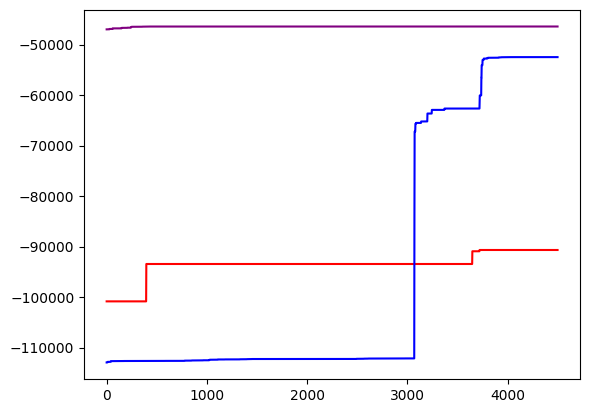

In [24]:
plt.plot(fit_2.fit_results["MCMC_chains_with_fluxes"][500:,1,-1],color="red")
plt.plot(fit_2.fit_results["MCMC_chains_with_fluxes"][500:,2,-1],color="purple")
plt.plot(fit_2.fit_results["MCMC_chains_with_fluxes"][500:,3,-1],color="blue")
#seem to mix well, burn-in after 1500 samples perhaps...